In [1]:
# # -*- coding: utf-8 -*-
# """
# Created on Wed Nov 22 13:31:30 2023

# @author: tranq
# """

import rasterio as rio
import earthpy.plot as ep
import pandas as pd
from rasterio.plot import reshape_as_image, reshape_as_raster
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with rio.open('raw_data/ESA WorldCover 2020.tif') as src:
    land_cover = src.read()
    profile = src.profile
    src.close()
    
with rio.open('outputs/ghana_prepped_2020.tif') as src:
    ghana_2020 = src.read()
    profile = src.profile
    src.close()
    
data = np.vstack([ghana_2020, land_cover])

# Separate train and test data geographically
train_set = data[..., 625:]
test_set = data[..., :625]

# TCC of the full area
# ep.plot_rgb(data, rgb = (3,2,1), stretch = True)

# Select smaller study area
study_area = train_set[:, :625, :625]

columns = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9",
           "B11", "B12", "NDVI", "MNDWI", "BSI", "VV", "VH", "M", "class"]

def prep_image_for_ml(image, columns):
    '''
    Parameters
    ----------
    image : 3D numpy array
        Consisting of 19 bands, including the classification.
    
    columns : list
        column names to be given to the dataframe. Must be same length as number of bands + labels
        
    labelled : Boolean
        Whether the image land use is labelled 

    Returns
    -------
    Dataframe without nans.

    '''
    # change from band, x, y to x, y, band
    # then reshape into z columns, where z is the number of bands
    image_array = reshape_as_image(study_area)
    
    # convert all pixels to rows
    ml_prep_array = image_array.reshape(-1, study_area.shape[0])
    
    train_data = pd.DataFrame(data = ml_prep_array, columns = columns)
    
    # Drop nas
    train_data_cleaned = train_data.dropna().reset_index(drop = True)
    
    return train_data_cleaned

train_data = prep_image_for_ml(study_area, columns)

In [3]:
train_data

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI,MNDWI,BSI,VV,VH,M,class
0,0.04170,0.03960,0.05370,0.04150,0.08130,0.19190,0.22910,0.23510,0.26200,0.26280,0.16700,0.08300,0.324104,-0.513367,-0.315381,-9.859929,-16.043137,0.619353,10.0
1,0.04260,0.04280,0.05890,0.04210,0.07660,0.20010,0.24680,0.25220,0.27610,0.27720,0.16700,0.08920,0.290649,-0.478530,-0.403549,-8.701408,-15.025683,0.633271,10.0
2,0.04155,0.04330,0.06350,0.04235,0.08735,0.23255,0.28300,0.29710,0.30840,0.27810,0.18425,0.09595,0.346955,-0.487386,-0.450805,-9.227271,-15.733819,0.630334,10.0
3,0.04145,0.04605,0.06025,0.04235,0.09245,0.23510,0.28190,0.29165,0.31590,0.30850,0.17645,0.09100,0.371662,-0.490917,-0.499086,-7.390610,-14.147544,0.656860,10.0
4,0.04145,0.04325,0.05805,0.04080,0.08865,0.23295,0.28995,0.29865,0.31800,0.30850,0.17650,0.08725,0.369641,-0.505010,-0.526340,-6.883329,-13.541492,0.662992,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390617,0.04490,0.04830,0.06640,0.05770,0.10800,0.20240,0.24760,0.25250,0.27310,0.26240,0.18500,0.10110,0.303561,-0.471758,-0.246937,-10.602810,-17.841477,0.627243,60.0
390618,0.04840,0.04550,0.06410,0.05710,0.10480,0.19720,0.23370,0.25270,0.26720,0.24700,0.18460,0.10340,0.294626,-0.484520,-0.179977,-9.643658,-16.216350,0.627082,60.0
390619,0.04955,0.05695,0.08245,0.07715,0.12945,0.20690,0.23805,0.24270,0.26385,0.23885,0.20780,0.12600,0.253146,-0.431869,-0.043323,-10.106316,-16.585650,0.621372,50.0
390620,0.05060,0.04980,0.07720,0.06370,0.12950,0.22820,0.27260,0.27630,0.28590,0.22140,0.20040,0.11730,0.340580,-0.443804,-0.248508,-8.890429,-14.428336,0.618744,10.0


### Class adjustments

y contains classes as follows
 - 10: Tree Cover 
 - 20: Shrubland
 - 30: Grassland
 - 40: Cropland
 - 50: Built-up
 - 60: Bare
 - 80: Water
 - 90: Herbaceous Wetland

We can probably combine Shrubland, Grassland, Cropland into the same class

Drop Herbaceous Wetland class

In [4]:
train_data = train_data[train_data['class'] != 90]

train_data

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI,MNDWI,BSI,VV,VH,M,class
0,0.04170,0.03960,0.05370,0.04150,0.08130,0.19190,0.22910,0.23510,0.26200,0.26280,0.16700,0.08300,0.324104,-0.513367,-0.315381,-9.859929,-16.043137,0.619353,10.0
1,0.04260,0.04280,0.05890,0.04210,0.07660,0.20010,0.24680,0.25220,0.27610,0.27720,0.16700,0.08920,0.290649,-0.478530,-0.403549,-8.701408,-15.025683,0.633271,10.0
2,0.04155,0.04330,0.06350,0.04235,0.08735,0.23255,0.28300,0.29710,0.30840,0.27810,0.18425,0.09595,0.346955,-0.487386,-0.450805,-9.227271,-15.733819,0.630334,10.0
3,0.04145,0.04605,0.06025,0.04235,0.09245,0.23510,0.28190,0.29165,0.31590,0.30850,0.17645,0.09100,0.371662,-0.490917,-0.499086,-7.390610,-14.147544,0.656860,10.0
4,0.04145,0.04325,0.05805,0.04080,0.08865,0.23295,0.28995,0.29865,0.31800,0.30850,0.17650,0.08725,0.369641,-0.505010,-0.526340,-6.883329,-13.541492,0.662992,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390617,0.04490,0.04830,0.06640,0.05770,0.10800,0.20240,0.24760,0.25250,0.27310,0.26240,0.18500,0.10110,0.303561,-0.471758,-0.246937,-10.602810,-17.841477,0.627243,60.0
390618,0.04840,0.04550,0.06410,0.05710,0.10480,0.19720,0.23370,0.25270,0.26720,0.24700,0.18460,0.10340,0.294626,-0.484520,-0.179977,-9.643658,-16.216350,0.627082,60.0
390619,0.04955,0.05695,0.08245,0.07715,0.12945,0.20690,0.23805,0.24270,0.26385,0.23885,0.20780,0.12600,0.253146,-0.431869,-0.043323,-10.106316,-16.585650,0.621372,50.0
390620,0.05060,0.04980,0.07720,0.06370,0.12950,0.22820,0.27260,0.27630,0.28590,0.22140,0.20040,0.11730,0.340580,-0.443804,-0.248508,-8.890429,-14.428336,0.618744,10.0


In [5]:
# Separate into X and y
X = train_data.drop(columns = "class")
y = train_data["class"]

y[(y == 20) | (y == 40)] = 30

In [6]:
# Make y categorical using label encoder
class_encoder = LabelEncoder().fit(y)
y = class_encoder.transform(y)

## pipeline for ML
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DummyClassifier(strategy="stratified"))
])

# Dummy F1 score is approximately 0.143 - should be relatively easy to beat
metrics = pd.DataFrame(cross_validate(pipe, X, y, cv = 10, scoring = "f1_macro"))

#print("Dummy metrics")
#print(metrics)
#print(metrics['test_score'].mean())

In [7]:
metrics['test_score'].mean()

0.19936832450415812

In [8]:
np.unique(y)

array([0, 1, 2, 3, 4], dtype=int64)

In [9]:
# X still contains around 300,000 samples
# Learning curve suggests that only 20,000 samples are needed for full training
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .2, stratify = y, random_state = 42)

In [10]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([60665,  4486,  1772, 11076,   125], dtype=int64))

## Imbalanced dataset

In some cases, the dataset can be highly unbalanced, like that above. We can use oversampling to try and balance out this dataset. There are several methods for this, including SMOTEN, which aims to create synthetic datapoints using a KNN-like algorithm.

Note that this can lead to overfitting

In [11]:
%%time
from imblearn.over_sampling import RandomOverSampler, SMOTEN

# SMOTEN is used for categorical features
# Sampling strategy allows you set how many samples of each class you want
# this takes a while becase it needs to make up values
ros = SMOTEN(random_state = 42, sampling_strategy={0: 60665, 1: 5000, 2: 5000, 3: 12000, 4: 2000})

X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)

In [12]:
np.unique(y_oversampled, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([60665,  5000,  5000, 12000,  2000], dtype=int64))

## KNN Hyperparameter Tuning

We find that the best KNN was with 3 neighbors and "l1"

In [42]:
# We found that KNN and RandomForest were the most successful. Let's try doing KNN first since it's faster
knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())

params = {
    # n_neighbours = 5 was most successful, 0.730 f1_score
    'kneighborsclassifier__n_neighbors': np.arange(3,8),
    'kneighborsclassifier__metric': ['minkowski', 'l1', 'l2']
}

knn_searcher = GridSearchCV(
    estimator=knn_pipe,
    param_grid=params, 
    cv = 10,
    verbose = 10,
    scoring = 'f1_macro',
    n_jobs = -1
).fit(X_oversampled, y_oversampled)

cv_results = pd.DataFrame(knn_searcher.cv_results_)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__metric,param_kneighborsclassifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.069561,0.012589,4.619124,0.083422,minkowski,3,"{'kneighborsclassifier__metric': 'minkowski', ...",0.657991,0.716013,0.707668,0.742122,0.764427,0.762830,0.769276,0.767161,0.766057,0.652524,0.730607,0.043026,7
1,0.087014,0.018851,4.463199,0.074151,minkowski,4,"{'kneighborsclassifier__metric': 'minkowski', ...",0.651776,0.721416,0.715727,0.739589,0.759486,0.758937,0.758267,0.759874,0.755326,0.642722,0.726312,0.042437,12
2,0.077119,0.016372,4.934292,0.322081,minkowski,5,"{'kneighborsclassifier__metric': 'minkowski', ...",0.666423,0.721886,0.715530,0.746739,0.763527,0.763196,0.766106,0.764464,0.760657,0.643691,0.731222,0.042058,5
3,0.087354,0.019316,5.162366,0.200387,minkowski,6,"{'kneighborsclassifier__metric': 'minkowski', ...",0.662947,0.710907,0.715186,0.741491,0.754996,0.755883,0.765117,0.760485,0.755961,0.634908,0.725788,0.042671,14
4,0.086961,0.019661,5.095727,0.379924,minkowski,7,"{'kneighborsclassifier__metric': 'minkowski', ...",0.667631,0.714126,0.712644,0.744026,0.758299,0.759443,0.764023,0.762869,0.760176,0.640261,0.728350,0.041811,10
5,0.074756,0.010019,19.658048,1.031898,l1,3,"{'kneighborsclassifier__metric': 'l1', 'kneigh...",0.659348,0.724329,0.710743,0.750040,0.772137,0.770905,0.773186,0.771467,0.763064,0.676278,0.737150,0.040370,1
6,0.085458,0.023007,22.708773,1.160819,l1,4,"{'kneighborsclassifier__metric': 'l1', 'kneigh...",0.655969,0.722431,0.719132,0.745588,0.762783,0.765370,0.762487,0.765826,0.756328,0.656919,0.731283,0.040720,4
7,0.089698,0.030773,22.783752,0.572099,l1,5,"{'kneighborsclassifier__metric': 'l1', 'kneigh...",0.667891,0.719615,0.713781,0.754985,0.767561,0.770179,0.769929,0.771722,0.761288,0.651000,0.734795,0.042665,2
8,0.078476,0.022125,20.218668,1.017989,l1,6,"{'kneighborsclassifier__metric': 'l1', 'kneigh...",0.667133,0.717248,0.717850,0.747987,0.759623,0.766626,0.759581,0.763567,0.760281,0.644309,0.730420,0.041310,9
9,0.080350,0.012588,21.006825,0.630894,l1,7,"{'kneighborsclassifier__metric': 'l1', 'kneigh...",0.670163,0.711694,0.712072,0.752581,0.759633,0.766739,0.766863,0.765462,0.764370,0.647547,0.731712,0.041883,3


In [48]:
# The best two results were metric = l1 and n_neighbours 3,5,7, with a 0.737 f1 score
cv_results.sort_values(by = "rank_test_score")[['param_kneighborsclassifier__metric', 'param_kneighborsclassifier__n_neighbors', 'mean_test_score']].head()

,param_kneighborsclassifier__metric,param_kneighborsclassifier__n_neighbors,mean_test_score
5,l1,3,0.737150
7,l1,5,0.734795
9,l1,7,0.731712
6,l1,4,0.731283
2,minkowski,5,0.731222


In [15]:
%%time
knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = 3, metric = 'l1'))

knn_pipe.fit(X_oversampled, y_oversampled)

y_pred = knn_pipe.predict(X_test)

CPU times: total: 8min 18s
Wall time: 2min 17s


In [16]:
# F1_score on unseen data was approximately 0.614 - some degree of overfitting
f1_score(y_test, y_pred, average = "macro")

0.614058029840289

## Confusion Matrix to assess results

Create a nice Confusion Matrix to see results.

Remember that Producer's accuracy is row-wise accuracy, while User's accuracy is column-wise.

In [27]:
def make_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, columns = labels, index = labels)
    
    fig, ax = plt.subplots()

    # prep labels
    label = None

    for row in cm:
        row_label = [f'{item}\n({(item / row.sum() * 100):.1f}%)' for item in row]

        if label is not None:
            label = np.vstack([label, row_label])
        else:
            label = np.array(row_label)
    
    print(label.shape)
    
    sns.heatmap(cm_df, 
                cmap = 'coolwarm',
                annot = label, 
                fmt = '', # note that this must be included if label is non-numeric
                cbar = False, 
                ax = ax)
    
    plt.title(f'Model\nF1 score: {f1_score(y_true, y_pred, average = "macro"):.2f}')
    plt.xticks(rotation=45, ha = 'right')
    plt.xlabel('Predicted Labels', size = 16, fontweight = 'bold')
    plt.ylabel('True Labels', size = 16, fontweight = 'bold')
    
    plt.show()

(5, 5)


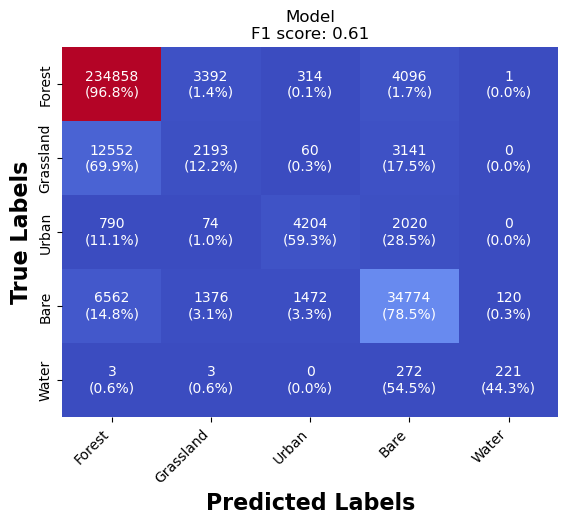

In [18]:
make_confusion_matrix(y_test, y_pred, ['Forest', 'Grassland', 'Urban', 'Bare', 'Water'])

In [28]:
def calculate_accuracies(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    PA = np.zeros(num_classes)
    UA = np.zeros(num_classes)

    for i in range(num_classes):
        # Producer's Accuracy
        PA[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[i, :])

        # User's Accuracy
        UA[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[:, i])

    return PA, UA

In [25]:
cm = confusion_matrix(y_test, y_pred)
labels = ['Forest', 'Grassland', 'Urban', 'Bare', 'Water']

PA, UA = calculate_accuracies(cm)

pd.DataFrame({"Producer Acc.": PA, "User Acc.": UA}, index = labels)

,Producer Acc.,User Acc.
Forest,0.967844,0.921861
Grassland,0.122200,0.311594
Urban,0.593115,0.694876
Bare,0.784895,0.784913
Water,0.442886,0.646199


In [ ]:
# We found that KNN and RandomForest were the most successful. Let's try doing KNN first since it's faster
knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())

params = {
    # n_neighbours = 5 was most successful, 0.730 f1_score
    'kneighborsclassifier__n_neighbors': np.arange(3,8),
    'kneighborsclassifier__metric': ['minkowski', 'l1', 'l2']
}

knn_searcher = GridSearchCV(
    estimator=knn_pipe,
    param_grid=params, 
    cv = 10,
    verbose = 10,
    scoring = 'f1_macro',
    n_jobs = -1
).fit(X_oversampled, y_oversampled)

cv_results = pd.DataFrame(knn_searcher.cv_results_)

## Random Forest Hyperparameter Tuning

Lots of hyperparameters, so use Randomized Search. Can fine tune later. 

In addition, RF allows for investigation of feature importance - might be able to cut down on features and increase speed without significantly reducing performance.

In [13]:
rf_pipe = make_pipeline(StandardScaler(), RandomForestClassifier())

params = {
    'randomforestclassifier__max_depth': np.arange(1,51),
    'randomforestclassifier__n_estimators': np.arange(30, 300),
    'randomforestclassifier__min_samples_split': np.arange(2,8),
    'randomforestclassifier__max_features': np.arange(1,8)
}

# param_distrib = [
#     {'max_depth': randint(low=1, high=50),
#      'n_estimators': randint(low=100, high=500),
#     'min_samples_split': randint(low=2, high=10),
#     'max_features': randint(low=1, high=8)}
# ]

search = RandomizedSearchCV(
    estimator = rf_pipe,
    param_distributions = params,
    cv = 5,
    n_jobs = -1,
    random_state = 42,
    n_iter = 40,
    scoring = 'f1_macro',
    verbose = 10
).fit(X_oversampled, y_oversampled)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [15]:
rf_results = pd.DataFrame(search.cv_results_)

# Looks like max_features is the best, max_depth around 45 is good
# n_estimators and min_samples_split are quite random
# Gridsearch estimators with lower fit times (90-150)
rf_results.sort_values(by = "rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__n_estimators,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__max_features,param_randomforestclassifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,211.166438,1.919884,0.668632,0.028540,90,7,7,46,"{'randomforestclassifier__n_estimators': 90, '...",0.670898,0.730427,0.774776,0.774043,0.725912,0.735211,0.038259,1
31,276.789780,1.455319,0.824570,0.052494,146,3,7,40,"{'randomforestclassifier__n_estimators': 146, ...",0.674291,0.727901,0.772703,0.774327,0.724250,0.734695,0.036930,2
25,619.034091,2.928765,1.898169,0.070945,262,2,7,43,"{'randomforestclassifier__n_estimators': 262, ...",0.672338,0.727056,0.774945,0.776325,0.722186,0.734570,0.038617,3
28,517.816217,4.605396,1.630199,0.425970,231,4,7,34,"{'randomforestclassifier__n_estimators': 231, ...",0.670651,0.726713,0.774638,0.775327,0.722541,0.733974,0.038877,4
22,439.718140,5.477416,1.962860,0.163324,259,4,5,31,"{'randomforestclassifier__n_estimators': 259, ...",0.670305,0.725472,0.772627,0.775570,0.724517,0.733698,0.038573,5


In [20]:
rf_pipe = make_pipeline(StandardScaler(), RandomForestClassifier(max_features=7, max_depth=45))

params = {
    'randomforestclassifier__n_estimators': [70,90,110,130,150],
    'randomforestclassifier__min_samples_split': [2,4,6,8]
}

search = GridSearchCV(
    estimator=rf_pipe,
    param_grid=params, 
    cv = 5,
    verbose = 10,
    scoring = 'f1_macro',
    n_jobs = -1
).fit(X_oversampled, y_oversampled)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [21]:
rf_results = pd.DataFrame(search.cv_results_)

# Looks like max_features is the best, max_depth around 45 is good
# n_estimators and min_samples_split are quite random
# Gridsearch estimators with lower fit times (90-150)
rf_results.sort_values(by = "rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,192.940585,1.614298,0.631125,0.076297,4,90,{'randomforestclassifier__min_samples_split': ...,0.677951,0.727742,0.774217,0.774417,0.724045,0.735674,0.036102,1
0,132.954859,1.761559,0.447950,0.024107,2,70,{'randomforestclassifier__min_samples_split': ...,0.674522,0.732734,0.774960,0.771725,0.724381,0.735664,0.036657,2
5,168.824931,5.151937,0.508620,0.156197,4,70,{'randomforestclassifier__min_samples_split': ...,0.672917,0.727863,0.776612,0.775489,0.725355,0.735647,0.038385,3
8,305.213143,6.722502,0.971947,0.136577,4,130,{'randomforestclassifier__min_samples_split': ...,0.671621,0.729362,0.774757,0.779533,0.722896,0.735634,0.039388,4
4,348.831768,5.098932,1.103785,0.190504,2,150,{'randomforestclassifier__min_samples_split': ...,0.675209,0.726605,0.773698,0.775912,0.725227,0.735330,0.037180,5


In [23]:
%%time
y_pred = search.best_estimator_.predict(X_test)

In [24]:
# F1_score on unseen data was approximately 0.616 - some degree of overfitting
# RandomForest predict is much faster than KNN
f1_score(y_test, y_pred, average = "macro")

0.6166384247657796

In [32]:
%%time
# Try fitting on X_train, y_train rather than oversampled
search.best_estimator_.fit(X_oversampled, y_oversampled)

y_pred = search.best_estimator_.predict(X_test)

CPU times: total: 2min 5s
Wall time: 2min 7s


In [35]:
# F1_score on unseen data was approximately 0.614 - some degree of overfitting
f1_score(y_test, y_pred, average = "macro")

0.6104016691936222

(5, 5)


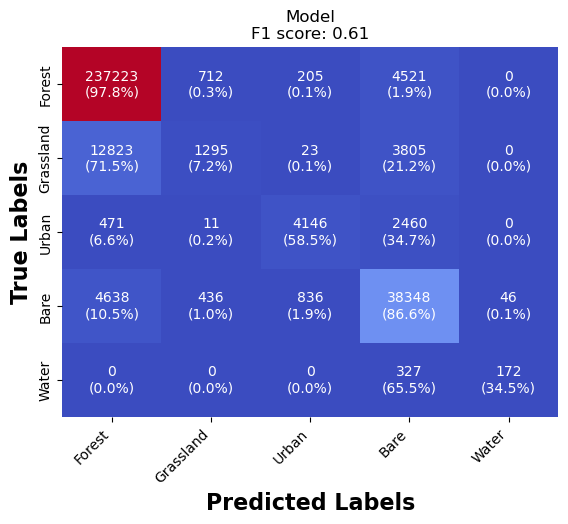

In [36]:
cm = confusion_matrix(y_test, y_pred)
labels = ['Forest', 'Grassland', 'Urban', 'Bare', 'Water']

make_confusion_matrix(y_test, y_pred, labels)

In [37]:
PA, UA = calculate_accuracies(cm)

accuracies = pd.DataFrame({"Producer Acc.": PA, "User Acc.": UA}, index = labels)

accuracies

,Producer Acc.,User Acc.
Forest,0.977590,0.929721
Grassland,0.072161,0.527710
Urban,0.584932,0.795777
Bare,0.865565,0.775318
Water,0.344689,0.788991


In [38]:
search.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=45, max_features=7,
                                        min_samples_split=4,
                                        n_estimators=90))])

In [39]:
import joblib

joblib.dump(search.best_estimator_, 'outputs/rf_model')

['outputs/rf_model']

In [ ]:
import joblib

joblib.dump(knn_pipe, 'outputs/knn_model')

In [3]:
# X still contains around 300,000 samples
# Learning curve suggests that only 20,000 samples are needed for full training
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .2, stratify = y)

params = {
    'model': [LogisticRegression(max_iter = 3000, class_weight='balanced'), 
              # Note that RandomForest is sensitive to imbalanced datasets
              RandomForestClassifier(), 
              LinearSVC(class_weight='balanced'), 
              KNeighborsClassifier()]
}

searcher = GridSearchCV(
    estimator=pipe,
    param_grid=params, 
    cv = 10,
    verbose = 10,
    scoring = 'f1_macro',
    n_jobs = -1
).fit(X_train, y_train)

cv_results = pd.DataFrame(searcher.cv_results_)

# Looks like KNeighbours was the best, followed by RandomForest()
cv_results

Fitting 10 folds for each of 4 candidates, totalling 40 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,20.552396,0.916178,0.008451,0.000817,"LogisticRegression(class_weight='balanced', ma...",{'model': LogisticRegression(class_weight='bal...,0.360822,0.363458,0.361687,0.365130,0.367102,0.364165,0.361349,0.366616,0.368044,0.369925,0.364830,0.002917,4
1,116.058620,4.303048,0.378553,0.109524,RandomForestClassifier(),{'model': RandomForestClassifier()},0.416067,0.455188,0.468286,0.456447,0.455796,0.427171,0.432715,0.444648,0.407660,0.402740,0.436672,0.021648,2
2,130.464546,9.420498,0.007364,0.001800,LinearSVC(class_weight='balanced'),{'model': LinearSVC(class_weight='balanced')},0.410604,0.449357,0.458607,0.472696,0.479763,0.451526,0.368441,0.418655,0.424462,0.426830,0.436094,0.031495,3
3,0.072682,0.012066,4.370699,0.427243,KNeighborsClassifier(),{'model': KNeighborsClassifier()},0.448904,0.490763,0.480313,0.486671,0.484007,0.458113,0.424545,0.444750,0.454513,0.444150,0.461673,0.021252,1
